# Imports

In [64]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

# Data importing

In [65]:
train = pd.read_csv('train.csv')

# Data exploration

In [16]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [17]:
#Let's get the dataset lenght
len(train)

27481

In [18]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [19]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [20]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [21]:
train["selected_text"].isnull().sum()

1

In [22]:
train["selected_text"].fillna("No content", inplace = True)

### Data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [23]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [24]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [26]:
len(data_words)

27481

In [27]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [28]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [16]:
data = np.array(data)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [29]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [30]:
len(labels)

27481

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [33]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [34]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [35]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


# Model building



## Single LSTM layer model

In [51]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
645/645 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.6489
Epoch 00001: val_accuracy improved from -inf to 0.76408, saving model to best_model1.hdf5
645/645 [==============================] - 58s 88ms/step - loss: 0.8051 - accuracy: 0.6489 - val_loss: 0.6391 - val_accuracy: 0.7641
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7729
Epoch 00002: val_accuracy improved from 0.76408 to 0.78868, saving model to best_model1.hdf5
645/645 [==============================] - 60s 92ms/step - loss: 0.5727 - accuracy: 0.7729 - val_loss: 0.5250 - val_accuracy: 0.7887
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8060
Epoch 00003: val_accuracy improved from 0.78868 to 0.80032, saving model to best_model1.hdf5
645/645 [==============================] - 59s 91ms/step - loss: 0.5025 - accuracy: 0.8060 - val_loss: 0.4979 - val_accuracy: 0.8003
Epoch 4/70
645/645 [=================

Epoch 27/70
645/645 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8746
Epoch 00027: val_accuracy improved from 0.84122 to 0.84180, saving model to best_model1.hdf5
645/645 [==============================] - 53s 83ms/step - loss: 0.3425 - accuracy: 0.8746 - val_loss: 0.4257 - val_accuracy: 0.8418
Epoch 28/70
645/645 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.8722
Epoch 00028: val_accuracy improved from 0.84180 to 0.84369, saving model to best_model1.hdf5
645/645 [==============================] - 54s 84ms/step - loss: 0.3436 - accuracy: 0.8722 - val_loss: 0.4236 - val_accuracy: 0.8437
Epoch 29/70
645/645 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8717
Epoch 00029: val_accuracy did not improve from 0.84369
645/645 [==============================] - 54s 83ms/step - loss: 0.3412 - accuracy: 0.8717 - val_loss: 0.4268 - val_accuracy: 0.8412
Epoch 30/70
645/645 [==============================] - ETA: 0s - loss

645/645 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8826
Epoch 00055: val_accuracy did not improve from 0.84675
645/645 [==============================] - 52s 81ms/step - loss: 0.3158 - accuracy: 0.8826 - val_loss: 0.4421 - val_accuracy: 0.8403
Epoch 56/70
645/645 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8828
Epoch 00056: val_accuracy did not improve from 0.84675
645/645 [==============================] - 48s 74ms/step - loss: 0.3153 - accuracy: 0.8828 - val_loss: 0.4434 - val_accuracy: 0.8396
Epoch 57/70
645/645 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8827
Epoch 00057: val_accuracy did not improve from 0.84675
645/645 [==============================] - 49s 75ms/step - loss: 0.3154 - accuracy: 0.8827 - val_loss: 0.4349 - val_accuracy: 0.8463
Epoch 58/70
645/645 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8837
Epoch 00058: val_accuracy did not improve from 0.84675
645/6

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [52]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model1.hdf5")

In [53]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 3s - loss: 0.4355 - accuracy: 0.8469 - 3s/epoch - 14ms/step
Model accuracy:  0.8468927145004272


In [54]:
predictions = best_model.predict(X_test)

## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [55]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<AxesSubplot:>

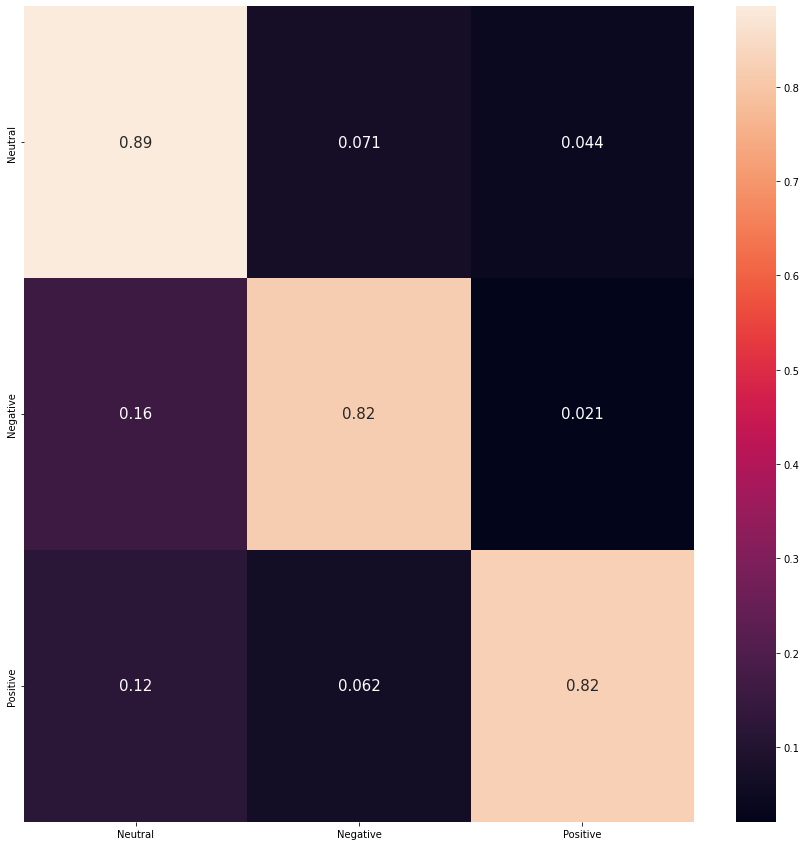

In [56]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [57]:
sentiment = ['Neutral','Negative','Positive']

In [58]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [59]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [60]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [61]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [80]:
sequence = tokenizer.texts_to_sequences(['it was not bad'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'